# Final project part 4 continuing data analysis and choosing a data model to fit and predict 

##GOAL: Exploring the dataset to create a model that accurately predicts number of rides a day using historcial trips of the prior days 

Features i'd intuitively think would be beneficial in my model as predictors would be trips of day lag 1, trips of day lag 2, temp. etc

In [107]:
%matplotlib inline
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score


In [118]:
df = pd.read_csv('../Data/daily_citi_bike_trip.csv') # reading in data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 15 columns):
date                   883 non-null object
trips                  883 non-null int64
precipitation          883 non-null float64
snow_depth             883 non-null float64
snowfall               883 non-null float64
max_temperature        883 non-null float64
min_temperature        883 non-null float64
average_wind_speed     880 non-null float64
dow                    883 non-null int64
year                   883 non-null int64
month                  883 non-null int64
holiday                883 non-null bool
stations_in_service    852 non-null float64
weekday                883 non-null bool
weekday_non_holiday    883 non-null bool
dtypes: bool(3), float64(7), int64(4), object(1)
memory usage: 85.4+ KB


In [187]:
df.describe()

/Users/linbrian/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,trips,precipitation,snow_depth,snowfall,max_temperature,min_temperature,average_wind_speed,dow,year,month,...,year_2014,year_2015,temp_lag1,temp_lag2,temp_lag3,temp_lag4,ride_lag1,ride_lag2,ride_lag3,ride_lag4
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,25200.730464,0.121271,0.973996,0.121945,64.273613,49.714813,5.226042,2.997735,2014.169875,6.952435,...,0.413364,0.378256,64.259184,64.239001,64.217750,64.191741,25210.425170,25213.223610,25217.029545,25220.318544
std,11835.247900,0.351795,3.036998,0.797992,19.227073,18.144775,2.244650,2.001132,0.747269,3.324819,...,0.492716,0.485227,19.222292,19.212955,19.202622,19.187168,11831.741294,11831.449729,11830.911639,11830.510690
min,876.000000,0.000000,0.000000,0.000000,17.240000,2.120000,0.671081,0.000000,2013.000000,1.000000,...,0.000000,0.000000,17.240000,17.240000,17.240000,17.240000,876.000000,876.000000,876.000000,876.000000
25%,14976.500000,0.000000,0.000000,0.000000,48.920000,35.960000,3.802790,1.000000,2014.000000,4.000000,...,0.000000,0.000000,48.920000,48.920000,48.920000,48.920000,14976.500000,14976.500000,14976.500000,14976.500000
50%,27142.000000,0.000000,0.000000,0.000000,68.000000,51.980000,4.921260,3.000000,2014.000000,7.000000,...,0.000000,0.000000,68.000000,68.000000,66.920000,66.920000,27142.000000,27142.000000,27142.000000,27142.000000
75%,34419.500000,0.039370,0.000000,0.000000,80.960000,64.940000,6.375270,5.000000,2015.000000,10.000000,...,1.000000,1.000000,80.960000,80.960000,80.960000,80.960000,34419.500000,34419.500000,34419.500000,34419.500000
max,52706.000000,4.968500,18.897600,10.984300,98.060000,82.940000,14.540100,6.000000,2015.000000,12.000000,...,1.000000,1.000000,98.060000,98.060000,98.060000,98.060000,52706.000000,52706.000000,52706.000000,52706.000000


In [221]:
df['date'] = pd.to_datetime(df['date']) # create a timestamp  in index
df.set_index('date', inplace=True)

In [120]:
df = df.join(pd.get_dummies(df['dow'], prefix='dow')) # Adding dow dummies

In [121]:
df = df.join(pd.get_dummies(df['year'], prefix='year')) # Adding year dummies

# Creating my lagged value as i noticed there were high correlations with partial auto correlation

In [189]:
df.loc[:,'temp_lag1'] = df.max_temperature.shift(-1)
df.loc[:,'temp_lag2'] = df.max_temperature.shift(-2)temp_lag5
df.loc[:,'temp_lag3'] = df.max_temperature.shift(-3)
df.loc[:,'temp_lag4'] = df.max_temperature.shift(-4)
df.loc[:,'temp_lag5'] = df.max_temperature.shift(-5)
df.loc[:,'temp_lag6'] = df.max_temperature.shift(-6)
df.loc[:,'temp_lag7'] = df.max_temperature.shift(-7)
df.loc[:,'ride_lag1'] = df.trips.shift(-1)
df.loc[:,'ride_lag2'] = df.trips.shift(-2)
df.loc[:,'ride_lag3'] = df.trips.shift(-3)
df.loc[:,'ride_lag4'] = df.trips.shift(-4)

# Filling the empty cells with a median value

In [194]:
df.temp_lag7= df.temp_lag7.fillna(df.temp_lag7.median())
df.temp_lag6= df.temp_lag6.fillna(df.temp_lag6.median())
df.temp_lag5= df.temp_lag5.fillna(df.temp_lag5.median())
df.temp_lag4= df.temp_lag4.fillna(df.temp_lag4.median())
df.temp_lag3= df.temp_lag3.fillna(df.temp_lag3.median())
df.temp_lag2= df.temp_lag2.fillna(df.temp_lag2.median())
df.temp_lag1= df.temp_lag1.fillna(df.temp_lag1.median())
df.ride_lag4= df.ride_lag4.fillna(df.ride_lag4.median())
df.ride_lag3= df.ride_lag3.fillna(df.ride_lag3.median())
df.ride_lag2= df.ride_lag2.fillna(df.ride_lag2.median())
df.ride_lag1= df.ride_lag1.fillna(df.ride_lag1.median())
df.average_wind_speed= df.average_wind_speed.fillna(df.average_wind_speed.median())


In [195]:
X = df[['temp_lag1', 'temp_lag2','temp_lag3','temp_lag4','temp_lag5','temp_lag6','temp_lag7','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6','ride_lag1','ride_lag2','ride_lag3','ride_lag4','precipitation','snowfall','snow_depth','year_2013','year_2014','year_2015','weekday_non_holiday','weekday']]
y = df['trips'].astype(float)

In [196]:
df.temp_lag1.isnull().values.any()
df.temp_lag1.isnull().any()

False

In [223]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 26 columns):
temp_lag1              883 non-null float64
temp_lag2              883 non-null float64
temp_lag3              883 non-null float64
temp_lag4              883 non-null float64
temp_lag5              883 non-null float64
temp_lag6              883 non-null float64
temp_lag7              883 non-null float64
dow_0                  883 non-null float64
dow_1                  883 non-null float64
dow_2                  883 non-null float64
dow_3                  883 non-null float64
dow_4                  883 non-null float64
dow_5                  883 non-null float64
dow_6                  883 non-null float64
ride_lag1              883 non-null float64
ride_lag2              883 non-null float64
ride_lag3              883 non-null float64
ride_lag4              883 non-null float64
precipitation          883 non-null float64
snowfall               883 non-null float64
snow_depth     

# Looking at this data set we do see there seems to be standardization in how the data is plotted over time. Perphaps a time series model may prove to be useful.

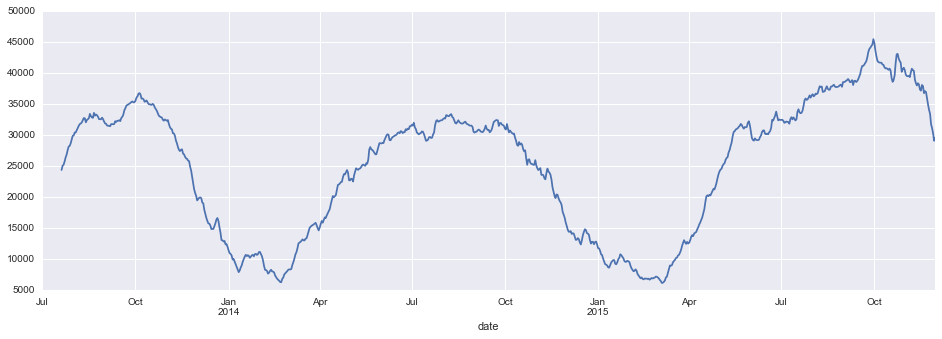

In [234]:
df.trips.resample('D').mean()\
.rolling(window=20, center=False).mean().plot(figsize=(16, 5));

# Plotting the trips data and temp by day we clearly see they are correlated

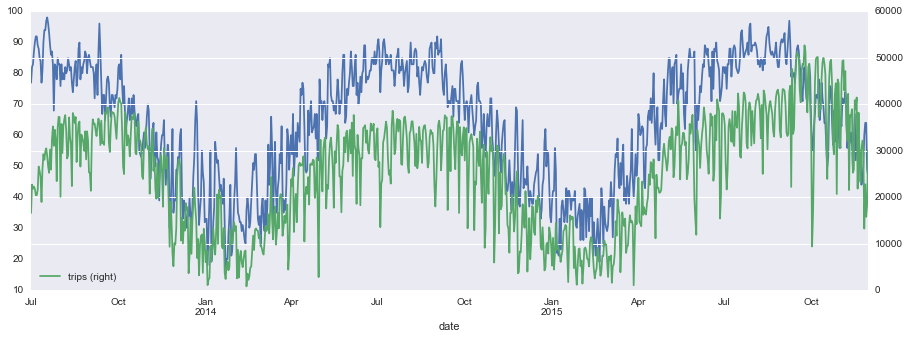

In [283]:
ax = df['max_temperature'].plot();
df['trips'].plot(ax=ax,secondary_y=True,legend= True,figsize=(15, 5));

# Max Temperature and number of rides are positively correlated

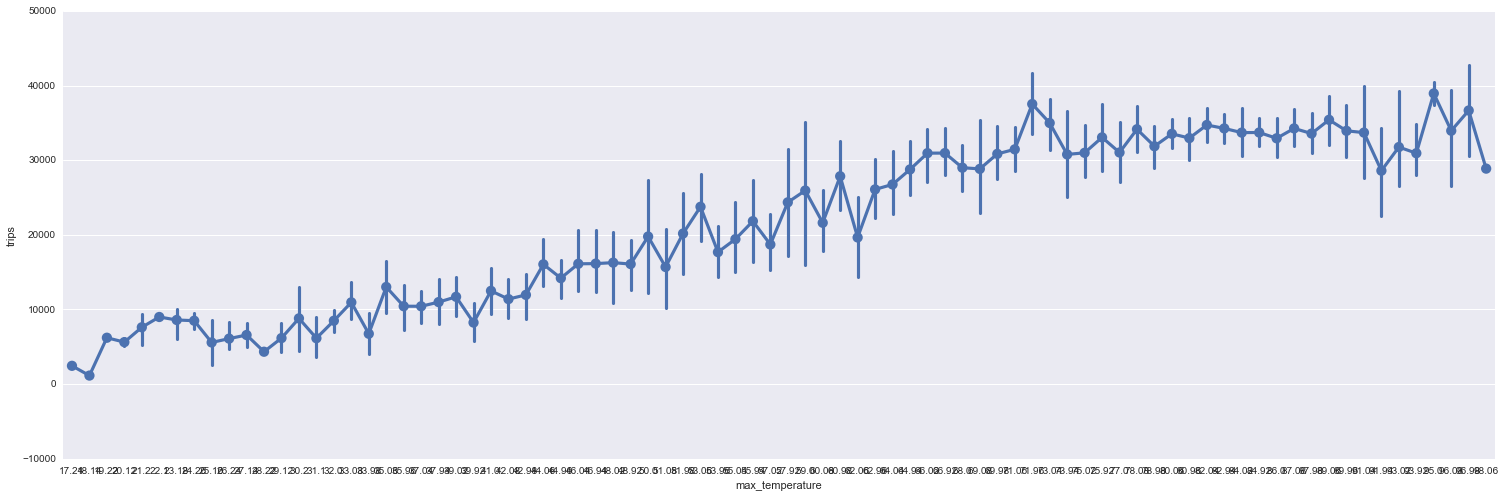

In [239]:
sns.factorplot(
    x='max_temperature',
    y='trips',
    data=df, 
    size=7, aspect=3,
    kind='point'
);

In [240]:
df.corr()

,trips,precipitation,snow_depth,snowfall,max_temperature,min_temperature,average_wind_speed,dow,year,month,...,temp_lag2,temp_lag3,temp_lag4,ride_lag1,ride_lag2,ride_lag3,ride_lag4,temp_lag5,temp_lag6,temp_lag7
trips,1.000000,-0.265424,-0.482982,-0.275754,0.782832,0.761090,-0.495310,0.010768,0.040581,0.424335,...,0.721124,0.699788,0.691431,0.852383,0.775116,0.747674,0.737997,0.683266,0.681213,0.674334
precipitation,-0.265424,1.000000,0.013341,0.233701,-0.032139,-0.009416,0.144011,0.015735,0.004526,-0.019262,...,-0.076686,-0.059740,-0.049571,-0.094951,-0.063648,-0.061090,-0.059997,-0.031757,-0.019949,-0.013135
snow_depth,-0.482982,0.013341,1.000000,0.265594,-0.476790,-0.490307,0.212690,0.011197,0.147300,-0.442731,...,-0.446012,-0.436439,-0.429811,-0.468386,-0.456685,-0.446894,-0.438706,-0.419021,-0.419461,-0.413249
snowfall,-0.275754,0.233701,0.265594,1.000000,-0.238976,-0.239173,0.208232,0.003555,0.042173,-0.193677,...,-0.241234,-0.236757,-0.223717,-0.249825,-0.239725,-0.229904,-0.221448,-0.212080,-0.183447,-0.214853
max_temperature,0.782832,-0.032139,-0.476790,-0.238976,1.000000,0.967770,-0.537243,-0.031472,-0.033304,0.300455,...,0.865658,0.842520,0.830736,0.754415,0.735000,0.728312,0.719778,0.827561,0.829259,0.832741
min_temperature,0.761090,-0.009416,-0.490307,-0.239173,0.967770,1.000000,-0.519611,-0.019307,-0.067676,0.356958,...,0.866871,0.846466,0.834008,0.748733,0.735012,0.726745,0.716393,0.826764,0.825687,0.825238
average_wind_speed,-0.495310,0.144011,0.212690,0.208232,-0.537243,-0.519611,1.000000,0.053280,0.043750,-0.212127,...,-0.461650,-0.445487,-0.429351,-0.453541,-0.403927,-0.399789,-0.367194,-0.429221,-0.414744,-0.408097
dow,0.010768,0.015735,0.011197,0.003555,-0.031472,-0.019307,0.053280,1.000000,0.003290,-0.010241,...,0.010370,0.030872,0.029333,-0.156289,-0.119014,-0.043759,0.047076,0.000383,-0.027879,-0.032573
year,0.040581,0.004526,0.147300,0.042173,-0.033304,-0.067676,0.043750,0.003290,1.000000,-0.355882,...,-0.021842,-0.014736,-0.009210,0.044315,0.047861,0.053107,0.057844,-0.003713,0.002902,0.012285
month,0.424335,-0.019262,-0.442731,-0.193677,0.300455,0.356958,-0.212127,-0.010241,-0.355882,1.000000,...,0.277171,0.262677,0.253645,0.412793,0.403333,0.388770,0.375189,0.244907,0.234241,0.216394


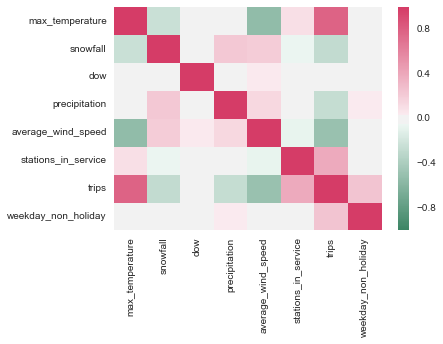

In [256]:
cmap = sns.diverging_palette(150, 1, as_cmap=True)
correlations = df[['max_temperature','snowfall','dow', 'precipitation', 'average_wind_speed', 'stations_in_service','trips','weekday_non_holiday']].corr()
sns.heatmap(correlations, cmap=cmap,);

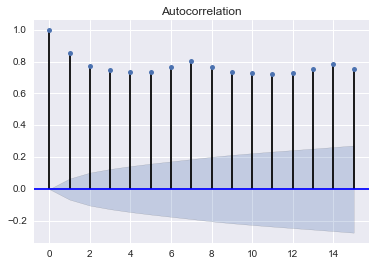

In [257]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.trips, lags=15);

# Looking at the partial autocorrelation we can see that there are some weekly trends and abouot 7 days out the lag features will be useful

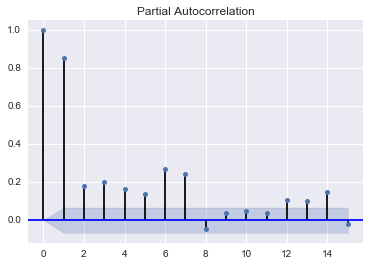

In [258]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.trips, lags=15);

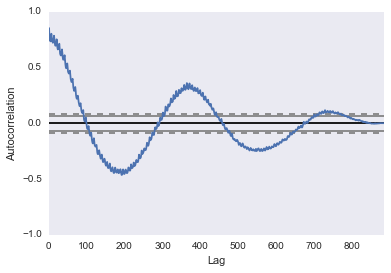

In [259]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df.trips);

# After Evaluating the dataset I'd like to explore using time series models such as AR, MA, ARMA and ARIMA

In [262]:
train= df[['trips']].astype(float).head(661)
test= df[['trips']].astype(float).tail(222)


In [270]:
time_model = sm.tsa.ARIMA(train, (7, 0, 0)).fit()
predictions = time_model.predict(
    661,
    882,
    dynamic=True, 
)

In [271]:
print "Mean absolute error: ", mean_absolute_error(test, predictions)
print time_model.summary()

Mean absolute error:  14182.1553045
                              ARMA Model Results                              
Dep. Variable:                  trips   No. Observations:                  661
Model:                     ARMA(7, 0)   Log Likelihood               -6573.003
Method:                       css-mle   S.D. of innovations           5030.870
Date:                Fri, 18 Nov 2016   AIC                          13164.006
Time:                        22:53:40   BIC                          13204.450
Sample:                    07-01-2013   HQIC                         13179.681
                         - 04-22-2015                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        2.178e+04   3858.545      5.643      0.000      1.42e+04  2.93e+04
ar.L1.trips     0.5128      0.038     13.463      0.000         0.438     0.587
ar.L2.trips 

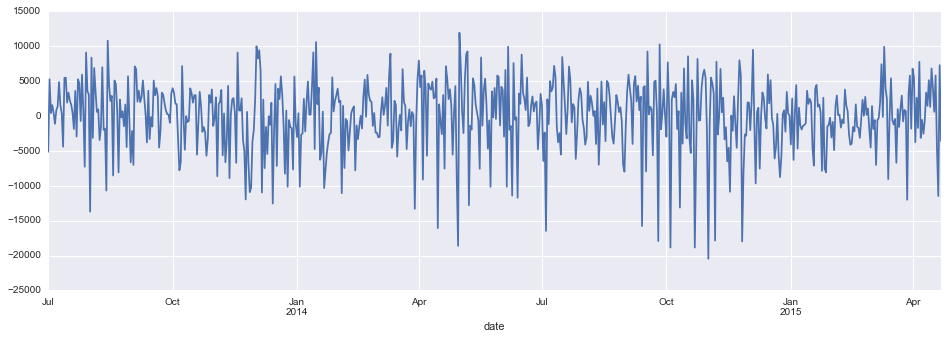

In [281]:
time_model.resid.plot(figsize=(16, 5));

# Ploting my predictions over the actuals i see that this isn't the right model for the job

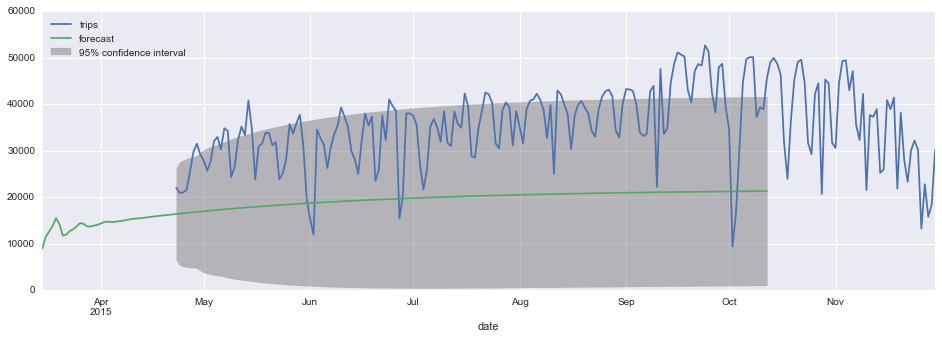

In [280]:
ax = test.plot(figsize=(16, 5))
time_model.plot_predict(622,833, ax=ax, plot_insample=False,dynamic =True,);

# My predictions converge to the mean within a month it would seem

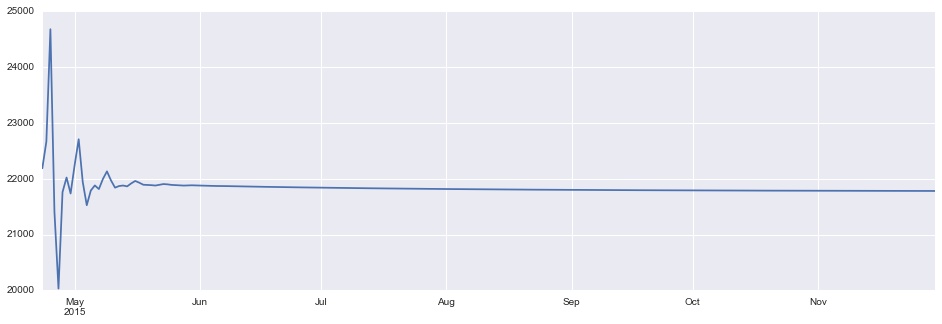

In [276]:
predictions.plot(figsize=(16, 5))

# Changing gears and trying Random Forest instead

In [198]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 1000)
model.fit(X, y)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [210]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, scoring='mean_squared_error', cv=5)

print('CV MAE {}, Mean squared error {}'.format(scores, (scores.mean()*-1)**.5))




CV MAE [-18502093.63930908 -17053267.14516925 -19166986.89543452
 -16817927.88307486 -59852276.1346256 ], Mean squared error 5126.25695216


In [206]:
mean_error = (scores.mean()*-1)**.5

5138.1510874049118

In [185]:
df.trips.describe()

count      883.000000
mean     25200.730464
std      11835.247900
min        876.000000
25%      14976.500000
50%      27142.000000
75%      34419.500000
max      52706.000000
Name: trips, dtype: float64

In [219]:

print('Percent error {}%'.format((mean_error /df.trips.mean() * 100)))

Percent error 20.434413139%


# This is my best model